In [1]:
from matplotlib import pyplot as plt
import numpy as np
import affine_invariant as af
from time import time

In [ ]:
plt.style.available

In [2]:
plt.style.use('seaborn-v0_8-bright') # I personally prefer seaborn for the graph style, but you may choose whichever you want.
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern"]}
plt.rcParams.update(params)

In [3]:
rhob = [
    0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018,
    0.0018, 0.0029, 0.0072, 0.0216, 0.0056, 0.0015
]
sigmaz = [
    3.7, 7.1, 22.1, 39.0, 15.5, 7.5, 12.0, 
    18.0, 18.5, 18.5, 20.0, 20.0]
rhoDM = [0.016]
sigmaDD = [7]
hDD = [65]
R = [3.4E-3]
zsun = [10]

sigmaw = [5.]
w0 = [-7.]

theta = np.array([rhob + sigmaz + rhoDM + sigmaDD + hDD + R + zsun + sigmaw + w0]).flatten()
theta.shape

(31,)

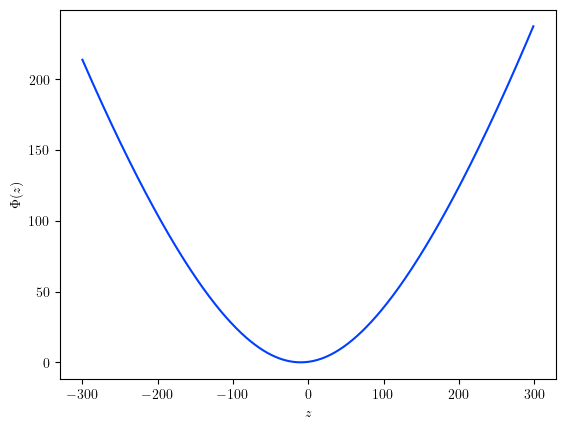

In [5]:
z_start = -300
z_end = 300
dz = 1.

z = np.arange(z_start, z_end, dz)

phi = af.potential(z, theta)

plt.plot(z, phi)
plt.xlabel(r'$z$')
plt.ylabel(r'$\Phi(z)$')
plt.show()


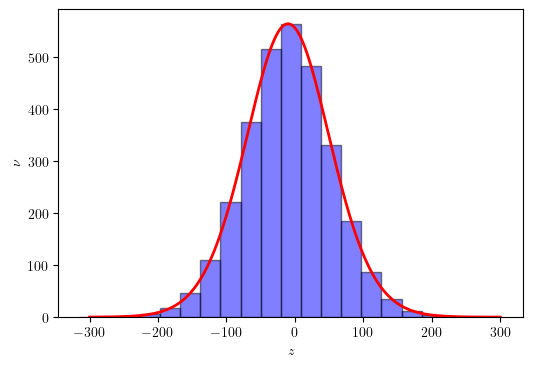

In [31]:
Nz = 3000
z = np.linspace(-300, 300, 205)
dz = z[10] - z[0]
Nz_mod = af.Nz1(z[::10], dz, Nz, theta)
Nz_smooth = af.Nz1(z, dz, Nz, theta)
plt.figure(figsize=(6, 4))
plt.bar(z[::10], Nz_mod, width=dz, color='b', alpha=0.5, ec="k")
plt.plot(z, Nz_smooth, color='r', lw=2)
plt.xlabel(r'$z$')
plt.ylabel(r'$\nu$')
plt.show()

In [32]:
Nz_mod.sum(), Nz_smooth.sum()

(3000.091224801576, 30000.074622442684)

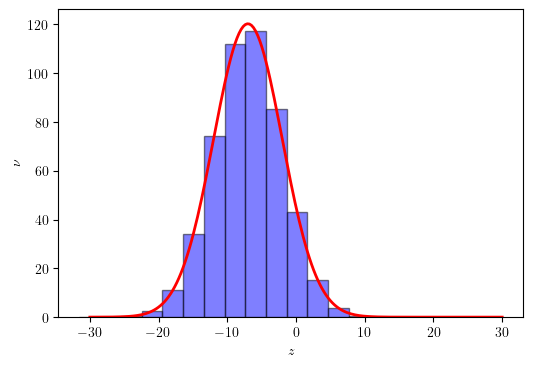

In [36]:
Nw = 500
w = np.linspace(-30, 30, 200)
zbound = 50
dw = w[10] - w[0]
Nw_mod = af.Nw1(w[::10], dw, Nw, zbound, theta)
Nw_smooth = af.Nw1(w, dw, Nw, zbound, theta)
plt.figure(figsize=(6, 4))
plt.bar(w[::10], Nw_mod, width=dw, color='b', alpha=0.5, ec="k")
plt.plot(w, Nw_smooth, color='r', lw=2)
plt.xlabel(r'$z$')
plt.ylabel(r'$\nu$')
plt.show()

In [37]:
Nw_mod.sum(), Nw_smooth.sum()

(500.0015287805488, 5000.001528774996)

# Testing... Abaikan

In [ ]:
from scipy.stats import norm

phi = lambda z, p: z**2/p
f0 = lambda w, s: norm.pdf(w, 0, s)

z = np.linspace(-200, 200, 100)
w = np.linspace(-30, 30, 100)

p = 400
s = 5

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(z, phi(z, p))
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$\Phi(z)$')
ax[1].plot(w, f0(w, s))
ax[1].set_xlabel(r'$w$')
ax[1].set_ylabel(r'$f_0(w)$')
plt.show()

In [ ]:
fzw_aksen = lambda z, w, theta: f0(np.sqrt(w**2+2*phi(z, theta[0])), theta[1])

w = np.linspace(-30, 30, 200)
z = np.linspace(-300, 300, 201)

W, Z = np.meshgrid(w, z)
theta = [p, s]
FZW = fzw_aksen(Z, W, theta)
A = 1/np.trapz(np.trapz(FZW, w), z)
print(A)

fzw = lambda z,w, theta: A*fzw_aksen(z, w, theta)

FZW = fzw(Z, W, theta)
# plot contour
plt.contourf(Z, W, FZW, 10, cmap='binary')
plt.xlabel(r'$z$')
plt.ylabel(r'$w$')
plt.show()

Volume = np.trapz(np.trapz(FZW, w), z)
print('Volume =', Volume)

In [ ]:
fz_aksen = lambda z, theta: np.exp(-phi(z, theta[0])/theta[1]**2)
fw_aksen = lambda w, theta: f0(w, theta[1])

In [ ]:
import emcee

N = 5000
ndim = 2
nwalker = 20

def log_prob(pos, theta):
    z, w = pos
    return np.log(fzw(z, w, theta))

p0 = np.random.rand(nwalker, ndim)

sampler = emcee.EnsembleSampler(nwalker, ndim, log_prob, args=(theta,))

In [ ]:
samples = sampler.run_mcmc(p0, 10000, progress=True)
chain = sampler.get_chain(discard=100)

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(chain[:, :, 0], color='black', alpha=0.1)
ax[0].set_ylabel(r'$z$')
ax[1].plot(chain[:, :, 1], color='black', alpha=0.1)
ax[1].set_xlabel(r'$n$')
ax[1].set_ylabel(r'$w$')
plt.show()


In [ ]:
flat_samples = sampler.get_chain(discard=100, flat=True)

zs = flat_samples[:, 0]

plt.figure(figsize=(10, 6))
plt.hist(zs, bins=50, density=True, color='black')
plt.plot(z, fz_mod, color='red', ls='--')
plt.xlabel(r'$z$')
plt.ylabel(r'$f_z(z)$')
plt.show()

In [ ]:
flat_chain = chain.reshape((-1, ndim))

z_raw = flat_chain[:, 0]
w_raw = flat_chain[:, 1]

# plot histogram
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(z_raw, bins=50, density=True, color='c', ec='black', lw=0.5)
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$p(z)$')
ax[1].hist(w_raw, bins=50, density=True, color='c', ec='black', lw=0.5)
ax[1].set_xlabel(r'$w$')
ax[1].set_ylabel(r'$p(w)$')
plt.show()

In [ ]:
Nz = 2000

indeks = np.arange(len(z_raw))

idx = np.random.choice(indeks, Nz, replace=False)
# idx = idx.sort()
# print(idx)
z = z_raw[idx]
w = w_raw[idx]
zbound = 50

mask = (z<zbound)*(z>-zbound)
w = w[mask]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(z, bins=20, density=True, color='c', ec='black', lw=0.5)
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$p(z)$')
ax[1].hist(w, bins=20, density=True, color='c', ec='black', lw=0.5)
ax[1].set_xlabel(r'$w$')
ax[1].set_ylabel(r'$p(w)$')
plt.show()

In [ ]:
znum, zedge = np.histogram(z, bins=20, range=(-300, 300))
wnum, wedge = np.histogram(w, bins=20, range=(-20, 20))

dz = zedge[1] - zedge[0]
dw = wedge[1] - wedge[0]

mask = znum>0
znum = znum[mask]

zmid = (zedge[1:] + zedge[:-1])/2
zmid = zmid[mask]

mask = wnum>0
wnum = wnum[mask]
wmid = (wedge[1:] + wedge[:-1])/2
wmid = wmid[mask]

zerr = np.sqrt(znum)
werr = np.sqrt(wnum)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].errorbar(zmid, znum, yerr=zerr, fmt='.', color='c', ecolor='black', elinewidth=0.5, capsize=2)
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$N(z)$')
ax[1].errorbar(wmid, wnum, yerr=werr, fmt='.', color='c', ecolor='black', elinewidth=0.5, capsize=2)
ax[1].set_xlabel(r'$w$')
ax[1].set_ylabel(r'$N(w)$')
plt.show()

znum.sum(), wnum.sum()

In [ ]:
from scipy.stats import uniform

def log_prior(theta):
    p, s = theta
    prob_z = uniform.logpdf(p, 100, 1000)
    prob_s = uniform.logpdf(s, 1, 10)
    return prob_z + prob_s

In [ ]:
def log_likelihood(theta, data):
    z, w = data
    zmid, znum, zerr, dz = z
    wmid, wnum, werr, dw = w

    Nz = np.sum(znum)
    Nw = np.sum(wnum)

    p, s, = theta
    z = np.linspace(zmid.min()*2, zmid.max()*2, 500)
    w = np.linspace(wmid.min()*2, wmid.max()*2, 500)
    
    Az = np.trapz(fz_aksen(z, theta), z)
    Aw = np.trapz(fw_aksen(w, theta), w)

    zmod = fz_aksen(zmid, theta)/Az*Nz*dz
    wmod = fw_aksen(wmid, theta)/Aw*Nw*dw

    resz = norm.logpdf(znum, zmod, zerr).sum()
    resw = norm.logpdf(wnum, wmod, werr).sum()

    return resz + resw

In [ ]:
def log_prob(theta, data):
    prior = log_prior(theta)
    if not np.isfinite(prior):
        return -np.inf
    return prior + log_likelihood(theta, data)

In [ ]:
zdata = (zmid, znum, zerr, dz)
wdata = (wmid, wnum, werr, dw)

data = (zdata, wdata)

In [ ]:
ndim = 2
nwalkers = 20

s0 = uniform.rvs(1,10, size=nwalker)
p0 = uniform.rvs(300,200, size=nwalker)

p0 = np.stack((p0, s0), axis=1)
p0.shape

In [ ]:
sampler = emcee.EnsembleSampler(nwalker, ndim, log_prob, args=(data,))

In [ ]:
samples = sampler.run_mcmc(p0, 100, progress=True)
chain = sampler.get_chain()

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(chain[:, :, 0], color='black', alpha=0.1)
ax[0].set_ylabel(r'$p$')
ax[1].plot(chain[:, :, 1], color='black', alpha=0.1)
ax[1].set_xlabel(r'$n$')
ax[1].set_ylabel(r'$s$')
plt.show()


In [ ]:
samples = sampler.run_mcmc(None, 1000, progress=True)
chain = sampler.get_chain(discard=100)

In [ ]:
chain = sampler.get_chain(discard=200)
chain.shape

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(chain[:, :, 0], color='black', alpha=0.1)
ax[0].set_ylabel(r'$p$')
ax[1].plot(chain[:, :, 1], color='black', alpha=0.1)
ax[1].set_xlabel(r'$n$')
ax[1].set_ylabel(r'$s$')
plt.show()

In [ ]:
flat = sampler.get_chain(discard=200, flat=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
Ntot = len(flat)
z = np.linspace(zmid.min(), zmid.max(), 500)
w = np.linspace(wmid.min(), wmid.max(), 500)
Nz = np.sum(znum)
Nw = np.sum(wnum)
for i in range(30):
    theta_i = flat[np.random.randint(Ntot)]
    Az = np.trapz(fz_aksen(z, theta_i), z)
    Aw = np.trapz(fw_aksen(w, theta_i), w)
    
    zmod = fz_aksen(z, theta_i)/Az*Nz*dz
    wmod = fw_aksen(w, theta_i)/Aw*Nw*dw
    ax[0].plot(z, zmod, color='c', alpha=0.1)
    ax[1].plot(w, wmod, color='c', alpha=0.1)
ax[0].errorbar(zmid, znum, yerr=zerr, fmt='.', color='c', ecolor='black', elinewidth=0.5, capsize=2)
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$N(z)$')
ax[1].errorbar(wmid, wnum, yerr=werr, fmt='.', color='c', ecolor='black', elinewidth=0.5, capsize=2)
ax[1].set_xlabel(r'$w$')
ax[1].set_ylabel(r'$N(w)$')
plt.show()